# Curso Transfer Learning

<img src="https://yaelmanuel.com/wp-content/uploads/2021/12/platzi-banner-logo-matematicas.png" width="500px">

---

## Creando nuestro propio Clasificador de Imágenes 🍃 🍂

En este lab aprenderás:

* [Pytorch](https://pytorch.org/)
* [Torchvision](https://pytorch.org/vision/stable/index.html)
* Descargar un dataset, prepararlo, entrenarlo, realizar finetuning y guardarlo.


### 1) Descarga del dataset 🤓

Utilizaremos un conjunto de imágenes de enfermedades de las hojas de arroz.
<br>Para más detalle acá se puede ver el dataset de Kaggle: [Rice Leafs Dataset](https://www.kaggle.com/datasets/shayanriyaz/riceleafs).


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=85422d447afe19c06366784715cc4fcaa9ef888520214936342a7112f129f9ee
  Stored in directory: /root/.cache/pip/wheels/9f/af/22/bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"carlosbustillo","key":"507f9f6ee972b4bcad76ddc3f00b2851"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s Corn-Leaf

ref                                                     title                                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  --------------------------------------  -----  -------------------  -------------  ---------  ---------------  
smaranjitghose/corn-or-maize-leaf-disease-dataset       Corn or Maize Leaf Disease Dataset      161MB  2020-11-11 13:39:07          16416        204  0.875            
qramkrishna/corn-leaf-infection-dataset                 Corn Leaf Infection Dataset              13GB  2020-10-17 14:58:10           3672         81  0.7058824        
rabbityashow/corn-leaf-diseasesnlb                      Corn Leaf Diseases(NLB)                  38MB  2021-04-13 19:01:36            445          8  0.8125           
nafishamoin/new-bangladeshi-crop-disease                New Bangladeshi Crop Disease              2GB  2022-09-27 08:35:14           2865         60  0.8125    

In [ ]:
!kaggle datasets download -d shayanriyaz/riceleafs

Dataset URL: https://www.kaggle.com/datasets/shayanriyaz/riceleafs
License(s): CC0-1.0
100% 14.9G/14.9G [02:48<00:00, 149MB/s]
100% 14.9G/14.9G [02:48<00:00, 95.0MB/s]


In [ ]:
!unzip 'riceleafs.zip'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144628.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144631.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144637.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144641.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144645.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144647.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144651.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144654.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144656.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144658.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144730.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144733.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144738.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144742.jpg  
  inflating: RiceLeafs/train/Hispa/IMG_20190419_144810.jpg  
  inflating: RiceLeafs/t

***Cambiamos el nombre de la carpeta "validation" por "val", para seguir la misma estructura del código de ejemplo anterior.***

In [ ]:
!mv /content/RiceLeafs/validation /content/RiceLeafs/val

***Uso de memoria para este ejemplo***

Por comodidad y disminuir el uso de memoria puedes eliminar  este archivo que ahora es innecesario: /content/riceleafs.zip

In [ ]:
!rm -rf /content/riceleafs.zip

También hay 2 carpetas iguales con las mismas imágenes pero estructura diferente.
<br>Vamos a borrar una de ellas: /content/riceleafs

In [ ]:
!rm -r /content/riceleafs

### 2) Preparación de la data 👌

#### 2.1) Instalamos las dependencias 🙌

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import ResNet50_Weights

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

#### 2.2) Tips de implementación 👀

In [ ]:
cudnn.benchmark = True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### 2.3) Data Augmentation 📷 📸

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### 2.4) Dataset, Dataloader y más data 🔍

In [ ]:
!ls

kaggle.json  RiceLeafs	sample_data


In [ ]:
data_dir = 'RiceLeafs'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

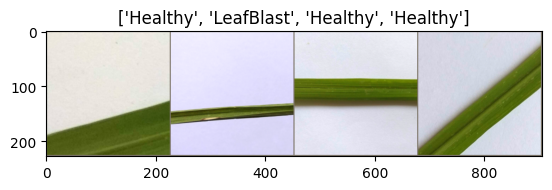

In [ ]:
def imshow(inp, title=None):
    """Imshow para tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pausarlo un poco para que se actualicen los plots


# Obtener un batch de datos de entrenamiento
inputs, classes = next(iter(dataloaders['train']))

# Crear una grilla con las imágenes
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

***Evaluar las class_names***

In [ ]:
print(class_names)

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']


### 3) Entrenamiento 💪

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Cada epoch tiene una fase de entrenamiento y validación.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Fase entrenamiento
            else:
                model.eval()   # Fase validación

            running_loss = 0.0
            running_corrects = 0

            # Iterar sobre la data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history solo si es la fase de entrenamiento
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize solo si es la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy el modelo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Cargar el best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 4) Finetuning de la convnet 😨

In [ ]:
model_ft = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features

In [ ]:
# Aquí el tamaño de cada muestra de salida se establece en len(class_names) = 4.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe que todos los parámetros están siendo optimizados
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decae LR por un factor de 0.1 cada 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

***Disminuir los epochs a 20 para evitar quedarse sin memoria en Google Colab.***

Utilizando la GPU T4, el entrenamiento duró 90 minutos.

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.7547 Acc: 0.7198
val Loss: 1.4524 Acc: 0.4352

Epoch 1/19
----------
train Loss: 0.7233 Acc: 0.7303
val Loss: 2.1184 Acc: 0.3636

Epoch 2/19
----------
train Loss: 0.7039 Acc: 0.7351
val Loss: 2.3173 Acc: 0.2966

Epoch 3/19
----------
train Loss: 0.6110 Acc: 0.7705
val Loss: 1.9584 Acc: 0.3398

Epoch 4/19
----------
train Loss: 0.5722 Acc: 0.7846
val Loss: 1.7638 Acc: 0.3964

Epoch 5/19
----------
train Loss: 0.5412 Acc: 0.8022
val Loss: 1.5012 Acc: 0.4665

Epoch 6/19
----------
train Loss: 0.5403 Acc: 0.7984
val Loss: 1.8367 Acc: 0.3905

Epoch 7/19
----------
train Loss: 0.5480 Acc: 0.7969
val Loss: 1.7517 Acc: 0.4292

Epoch 8/19
----------
train Loss: 0.5260 Acc: 0.8085
val Loss: 1.8449 Acc: 0.4128

Epoch 9/19
----------
train Loss: 0.5135 Acc: 0.8133
val Loss: 1.7861 Acc: 0.4486

Epoch 10/19
----------
train Loss: 0.5021 Acc: 0.8253
val Loss: 1.6036 Acc: 0.4888

Epoch 11/19
----------
train Loss: 0.4839 Acc: 0.8316
val Loss: 2.1749 Acc: 0.3607

Ep

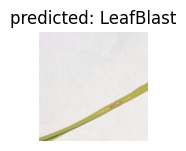

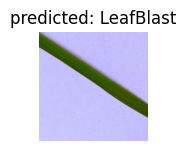

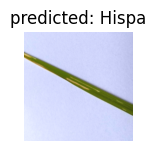

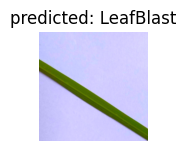

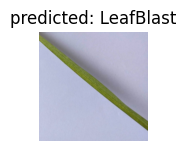

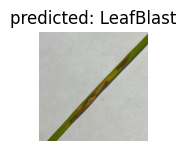

In [ ]:
visualize_model(model_ft)

### 5) Guardar el modelo 💾

In [ ]:
torch.save(model_ft, "model.pth")

### 6) Hacer Predicciones en Producción 🤙

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

Cargar el modelo una vez (al inicio de la aplicación)

In [ ]:
# Determinar el dispositivo
mi_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo en el dispositivo
mi_modelo = torch.load("model.pth", map_location=mi_device, weights_only=False)
mi_modelo.eval()
mi_modelo.to(mi_device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Función para predicción / inferencia

In [ ]:
def predict_image(image_path, model, class_names, device):
    """
    Predice la clase de una imagen usando un modelo entrenado.

    Args:
        image_path (str): Ruta de la imagen.
        model (torch.nn.Module): Modelo ya cargado y configurado para inferencia.
        class_names (list): Lista de nombres de clases.
        device (torch.device): Dispositivo donde está el modelo.

    Returns:
        str: Clase predicha.
    """
    # Preprocesamiento de la imagen
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Cargar y preprocesar la imagen
    image = Image.open(image_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)  # Añadir dimensión batch y mover al dispositivo

    # Realizar predicción
    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)

    # Retornar la clase predicha
    return class_names[preds[0].item()]


Ejemplos de uso

In [ ]:
class_names = ['Brown Spot', 'Healthy', 'Hispa', 'Leaf Blast']

In [ ]:
path_image = "/content/RiceLeafs/val/LeafBlast/IMG_4879.jpg"

predicted_class = predict_image(path_image, mi_modelo, class_names, mi_device)
print(f"La clase predicha es: {predicted_class}")

La clase predicha es: Leaf Blast


In [ ]:
path_image = "/content/RiceLeafs/val/Hispa/IMG_20190419_095946.jpg"

predicted_class = predict_image(path_image, mi_modelo, class_names, mi_device)
print(f"La clase predicha es: {predicted_class}")

La clase predicha es: Hispa


In [ ]:
path_image = "/content/RiceLeafs/val/Healthy/IMG_3232.jpg"

predicted_class = predict_image(path_image, mi_modelo, class_names, mi_device)
print(f"La clase predicha es: {predicted_class}")

La clase predicha es: Healthy


In [ ]:
path_image = "/content/RiceLeafs/val/BrownSpot/IMG_5488.jpg"

predicted_class = predict_image(path_image, mi_modelo, class_names, mi_device)
print(f"La clase predicha es: {predicted_class}")

La clase predicha es: Hispa


### 7) Conclusiones

- Aprender sobre los distintos objetos y métodos que nos ofrece Pytorch / Torchvision.

- Realizar el proceso completo de clasificación de imágenes con Pytorch.

- Aprender tips sobre implementación con el uso de la GPU.

<br>
<br>
<br>

---

<br>
<br>


<img src="https://static.platzi.com/media/avatars/platziteam_8cfe6fc7-1246-4c9a-9f5d-d10d467443ee.png" width="100px">

[Platzi](https://platzi.com/) 🚀

